In [1]:
import xarray as xr
import numpy as np
import pandas as pd
from tqdm import tqdm
import gc
import matplotlib.pyplot as plt
import numpy.ma as ma
import matplotlib.colors as colors

# plt.style.use('science')

def polyfit(x, y, degree):
    results = {}
    coeffs = np.polyfit(x, y, degree)
     # Polynomial Coefficients
    results['polynomial'] = coeffs.tolist()
    correlation = np.corrcoef(x, y)[0,1]
     # r
    results['correlation'] = correlation
     # r-squared
    results['determination'] = correlation**2

    return results

In [2]:
chi_ls = ["chi_b","chi_c","chi_h"]
aero_ls = ['Mass_so4','Mass_bc','Mass_ncl','Mass_dst','Mass_pom','Mass_soa']
gas_ls = ['DMS_SRF','H2O2_SRF','H2SO4_SRF','O3_SRF','SO2_SRF','SOAG_SRF']
ds_species = xr.open_dataset("/data/keeling/a/zzheng25/d/mam4_paper_data/chi_only/aero_gas_species/"
                             +"2011_aero_and_gas.nc")\
                             .drop(chi_ls)
diff_path = "/data/keeling/a/zzheng25/d/mam4_paper_data/chi_only/mam4_minus_ml_chi/"
abs_diff_path = "/data/keeling/a/zzheng25/d/mam4_paper_data/chi_only/mam4_minus_ml_chi/"
mask_path = "/data/keeling/a/zzheng25/d/mam4_paper_data/chi_only/mask/"

In [3]:
# get chi diff with mask
year = "2011"
temp_diff = []
temp_diff_abs = []
for chi in chi_ls:
    temp_mask = xr.open_dataset(mask_path+str(year)+"_"+chi+".nc")["mask"]
    temp_diff.append(xr.open_dataset(diff_path+year+"_"+chi+"_mean.nc").where(temp_mask))
    temp_diff_abs.append(xr.open_dataset(diff_path+year+"_"+chi+"_mean_abs.nc").where(temp_mask))
ds_diff = xr.merge(temp_diff)
ds_diff_abs = xr.merge(temp_diff_abs)

In [4]:
# merge chi diff with species
df_diff = xr.merge([ds_diff,ds_species])\
          .sel(lat=slice(-50.0,50.0)).to_dataframe().reset_index()
df_diff["dst_fraction"] = df_diff['Mass_dst']/(df_diff[aero_ls].sum(axis=1))

df_diff_abs = xr.merge([ds_diff_abs,ds_species])\
          .sel(lat=slice(-50.0,50.0)).to_dataframe().reset_index()
df_diff_abs["dst_fraction"] = df_diff_abs['Mass_dst']/(df_diff_abs[aero_ls].sum(axis=1))

In [5]:
rc={'axes.labelsize': 12,
    'font.size': 12, 'legend.fontsize': 12, 
    'axes.titlesize': 12,
    'xtick.labelsize': 12.0,
    'ytick.labelsize': 12.0}
plt.rcParams.update(**rc)

xedges = list(np.arange(0,100,1))
yedges = list(np.arange(0,100,1))
ticks=[0,20,40,60,80,100]
x=df_diff_abs["dst_fraction"]*100.0
y=df_diff_abs["chi_h"]*100.0

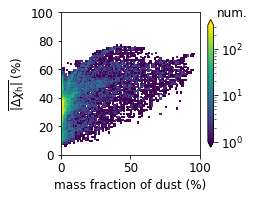

In [6]:
fig = plt.figure(figsize=(3.7,3.0))
ax = fig.add_subplot(111)
H, xedges, yedges = np.histogram2d(x,y, bins=(xedges, yedges))
H = H.T
H=ma.masked_where(H==0,H)
X, Y = np.meshgrid(xedges, yedges)

p = ax.pcolormesh(X, Y, H,
               norm=colors.LogNorm(vmin=H.min(), vmax=H.max()),edgecolor="face", linewidth=0.00, rasterized=True)

clb=plt.colorbar(p,orientation='vertical',fraction=0.038,extend='both',ax=ax)
clb.set_label('num.', labelpad=-10, y=1.1, rotation=0)

ax.set_xlabel("mass fraction of dust (%)")
ax.set_ylabel(r'$\overline{|\Delta\chi_{\rm{h}}|}$'+" (%)")
ax.set_xlim(0,100)
ax.set_ylim(0,100)

plt.tight_layout()
plt.savefig("../figures/abs_diff_chi_to_dst_frac.pdf",dpi=288)